In [4]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
path = "Fashion Landmark Detection Benchmark/"

In [8]:
class IdentityMetadata():
    def __init__(self, base, file):
        # dataset base directory
        self.base = base
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.file) 
    
def load_metadata(path):
    metadata = []
    for f in sorted(os.listdir(path)):
        # Check file extension. Allow only jpg/jpeg' files.
        ext = os.path.splitext(f)[1]
        if ext == '.jpg' or ext == '.jpeg':
            metadata.append(IdentityMetadata(path, f))
    return np.array(metadata)

In [9]:
metadata = load_metadata(path+"img")

In [10]:
metadata

array([Fashion Landmark Detection Benchmark/img/img_00000001.jpg,
       Fashion Landmark Detection Benchmark/img/img_00000002.jpg,
       Fashion Landmark Detection Benchmark/img/img_00000003.jpg, ...,
       Fashion Landmark Detection Benchmark/img/img_00123057.jpg,
       Fashion Landmark Detection Benchmark/img/img_00123058.jpg,
       Fashion Landmark Detection Benchmark/img/img_00123059.jpg],
      dtype=object)

In [11]:
bbox = pd.read_csv(path+"Anno/list_bbox.txt")
bbox.head()

# joints = pd.read_csv(path+"Anno/list_joints.txt")
# joints.head()

,image_name x_1 y_1 x_2 y_2
0,img/img_00000001.jpg 053 130 289 440
1,img/img_00000002.jpg 053 095 207 208
2,img/img_00000003.jpg 041 097 244 295
3,img/img_00000004.jpg 026 059 165 186
4,img/img_00000005.jpg 126 122 349 333


In [12]:
landmarks = pd.read_csv(path+"Anno/list_landmarks.txt")
landmarks.head(2)

,image_name clothes_type variation_type landmark_visibility_1 landmark_location_x_1 landmark_location_y_1 landmark_visibility_2 landmark_location_x_2 landmark_location_y_2 landmark_visibility_3 landmark_location_x_3 landmark_location_y_3 landmark_visibility_4 landmark_location_x_4 landmark_location_y_4 landmark_visibility_5 landmark_location_x_5 landmark_location_y_5 landmark_visibility_6 landmark_location_x_6 landmark_location_y_6 landmark_visibility_7 landmark_location_x_7 landmark_location_y_7 landmark_visibility_8 landmark_location_x_8 landmark_location_y_8
0,img/img_00000001.jpg 1 1 1 144 156 1 221 1...
1,img/img_00000002.jpg 1 3 0 111 104 1 153 1...


In [13]:
landmarks.columns

Index(['image_name  clothes_type  variation_type  landmark_visibility_1 landmark_location_x_1 landmark_location_y_1  landmark_visibility_2 landmark_location_x_2 landmark_location_y_2  landmark_visibility_3 landmark_location_x_3 landmark_location_y_3  landmark_visibility_4 landmark_location_x_4 landmark_location_y_4  landmark_visibility_5 landmark_location_x_5 landmark_location_y_5  landmark_visibility_6 landmark_location_x_6 landmark_location_y_6  landmark_visibility_7 landmark_location_x_7 landmark_location_y_7  landmark_visibility_8 landmark_location_x_8 landmark_location_y_8 '], dtype='object')

In [16]:
# x,y,w,h = cv2.boundingRect(cnt)
# cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

image_name   clothes_type    variation_type <br/>
landmark_visibility_1 landmark_location_x_1 landmark_location_y_1  <br/>
landmark_visibility_2 landmark_location_x_2 landmark_location_y_2  <br/>
landmark_visibility_3 landmark_location_x_3 landmark_location_y_3  <br/>
landmark_visibility_4 landmark_location_x_4 landmark_location_y_4  <br/>
landmark_visibility_5 landmark_location_x_5 landmark_location_y_5  <br/>
landmark_visibility_6 landmark_location_x_6 landmark_location_y_6  <br/>
landmark_visibility_7 landmark_location_x_7 landmark_location_y_7  <br/>
landmark_visibility_8 landmark_location_x_8 landmark_location_y_8  <br/>

In [17]:
list = []
for i in range(10):#len(landmarks)):
    landmark = (landmarks.iloc[i][0]).split()[3:]
    coord = []
    for j in range(int(len(landmark)/3)):
        coord.append([int(landmark[j+1]),int(landmark[j+2])])
    list.append(np.array(coord))

In [18]:
list[0].shape

(6, 2)

In [20]:
# x,y,w,h = cv2.boundingRect(list[0])
# cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
# cv2.imshow()

# rect = cv.minAreaRect(cnt)
# box = cv.boxPoints(rect)
# box = np.int0(box)
# cv.drawContours(img,[box],0,(0,0,255),2)

In [23]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

def show_original_and_aligned(img_index):
    plt.figure(figsize=(10,10))
    original = load_image(metadata[img_index].image_path())
    
    landmark = (landmarks.iloc[img_index][0]).split()[3:]
    coord = []
    for j in range(int(len(landmark)/3)):
        coord.append([int(landmark[j+1]),int(landmark[j+2])])
    x,y,w,h = cv2.boundingRect(np.array(coord))
    img = cv2.imread(metadata[img_index].image_path(), 1)[...,::-1]
    bbox = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    plt.imshow("bbox", bbox)

#     # Detect face and return bounding box
#     bb = alignment.getLargestFaceBoundingBox(original)

#     # Transform image using specified face landmark indices and crop image to 96x96
#     aligned = alignment.align(96, original, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

    # Show original image
    plt.subplot(131)
    plt.imshow(original)

#     # Show original image with bounding box
#     plt.subplot(132)
#     plt.imshow(original)
#     plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

#     # Show aligned image
#     plt.subplot(133)
#     plt.imshow(aligned)

ValueError: Colormap <UMat 0x7f0ac0973070> is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r

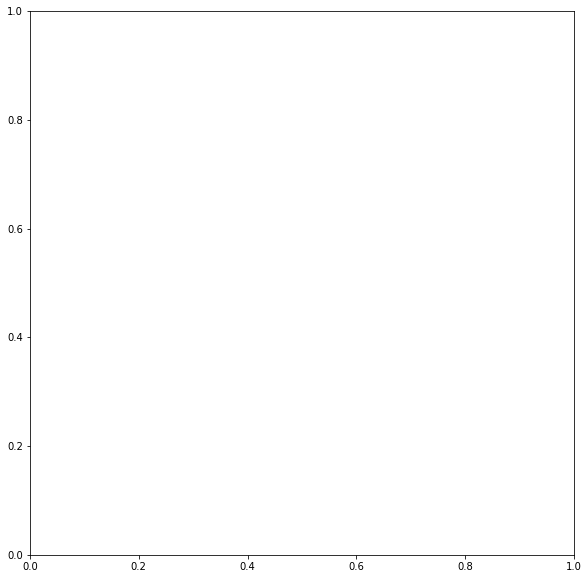

In [24]:
show_original_and_aligned(10)

In [58]:
sa = landmarks.iloc[0][0]
sa

'img/img_00000001.jpg  1  1  1 144 156  1 221 159  0 086 218  1 250 238  0 111 408  0 237 412 '

In [62]:
a = sa.split()
a[2:]

['1',
 '1',
 '144',
 '156',
 '1',
 '221',
 '159',
 '0',
 '086',
 '218',
 '1',
 '250',
 '238',
 '0',
 '111',
 '408',
 '0',
 '237',
 '412']

In [74]:
cv2.imshow("im",str(metadata[0]))

TypeError: 'str' object is not callable

In [86]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

def show_original_and_aligned(img_index):
    plt.figure(figsize=(10,10))
    original = load_image(metadata[img_index].image_path())
    
    

#     # Detect face and return bounding box
#     bb = alignment.getLargestFaceBoundingBox(original)

#     # Transform image using specified face landmark indices and crop image to 96x96
#     aligned = alignment.align(96, original, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

    # Show original image
    plt.subplot(131)
    plt.imshow(original)

#     # Show original image with bounding box
#     plt.subplot(132)
#     plt.imshow(original)
#     plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

#     # Show aligned image
#     plt.subplot(133)
#     plt.imshow(aligned)

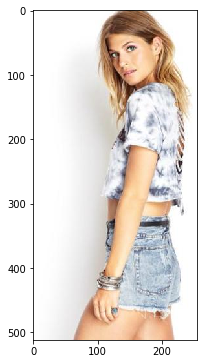

In [89]:
show_original_and_aligned(10)

In [75]:
os.getcwd()

'/home/aaradhya/repo/tensorflow-models/research/object_detection/fashion-landmark'